# ================================================================================
# Modelo Machine Learning
# ================================================================================



# 1. IMPORTACIÓN DE LIBRERÍAS


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)

import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("Librerías importadas correctamente")


Librerías importadas correctamente


# ================================================================================
# 2. DESCRIPCIÓN DEL PROYECTO
# ================================================================================


In [2]:
descripcion = """
OBJETIVO:
Desarrollar modelos de machine learning para predecir el abandono (churn) de 
clientes en base a sus patrones de comportamiento transaccional y características
demográficas.

DEFINICIÓN DE CHURN:
Un cliente es considerado en churn si su recency (días desde última transacción)
es mayor o igual a 42 días.

DATASET:
- Total de registros: 872,249
- Variable objetivo: churn (binaria: 0/1)
- Variables predictoras: 34 variables iniciales
"""

print(descripcion)



OBJETIVO:
Desarrollar modelos de machine learning para predecir el abandono (churn) de 
clientes en base a sus patrones de comportamiento transaccional y características
demográficas.

DEFINICIÓN DE CHURN:
Un cliente es considerado en churn si su recency (días desde última transacción)
es mayor o igual a 42 días.

DATASET:
- Total de registros: 872,249
- Variable objetivo: churn (binaria: 0/1)
- Variables predictoras: 34 variables iniciales



# ================================================================================
# 3. CARGA Y EXPLORACIÓN INICIAL DE DATOS
# ================================================================================

In [3]:
print("CARGA DE DATOS")


# Cargar dataset
archivo = 'BaseDeDatos.csv'
df = pd.read_csv(archivo)

print(f"\nArchivo cargado: {archivo}")
print(f"Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas")

# Vista previa
print("\nPrimeras 5 filas:")
print(df.head())

# Información general
print("\nInformación del dataset:")
print(df.info())

# Valores nulos
print("\nValores nulos por columna:")
nulls = df.isnull().sum()
if nulls.sum() > 0:
    print(nulls[nulls > 0])
else:
    print("No hay valores nulos")

CARGA DE DATOS

Archivo cargado: BaseDeDatos.csv
Dimensiones: 872,249 filas x 34 columnas

Primeras 5 filas:
  creationflow  age  gender      occupation  qualification state usertype  \
0          POS   25  female            Otro              2    VE   HYBRID   
1          POS   44    male        Empleado              2    NL   HYBRID   
2       MOBILE   32  female        Empleado              2    SO  DIGITAL   
3       MOBILE   40  female  Negocio propio              2    BC   HYBRID   
4          POS   35  female        Empleado              3    EM   HYBRID   

        userchannel  id_user  tx_count  amount_sum  amount_mean  amount_p95  \
0               POS   456279       5.0    1072.500   214.500000     346.500   
1               POS   893351     153.0   87431.223   571.445902    1732.500   
2  REFERRAL_ORGANIC    72225      20.0    5295.400   264.770000     445.995   
3           ORGANIC   740707      61.0   30916.908   506.834557    1178.100   
4               POS   333626     

# ================================================================================
# 4. ANÁLISIS DE LA VARIABLE OBJETIVO
# ================================================================================


ANÁLISIS DE VARIABLE OBJETIVO: CHURN

Distribución de churn:
No Churn (0): 576,296 (66.07%)
Churn (1):    295,953 (33.93%)

Balance de clases: LIGERAMENTE DESBALANCEADO
Recomendación: Usar class_weight='balanced' en los modelos


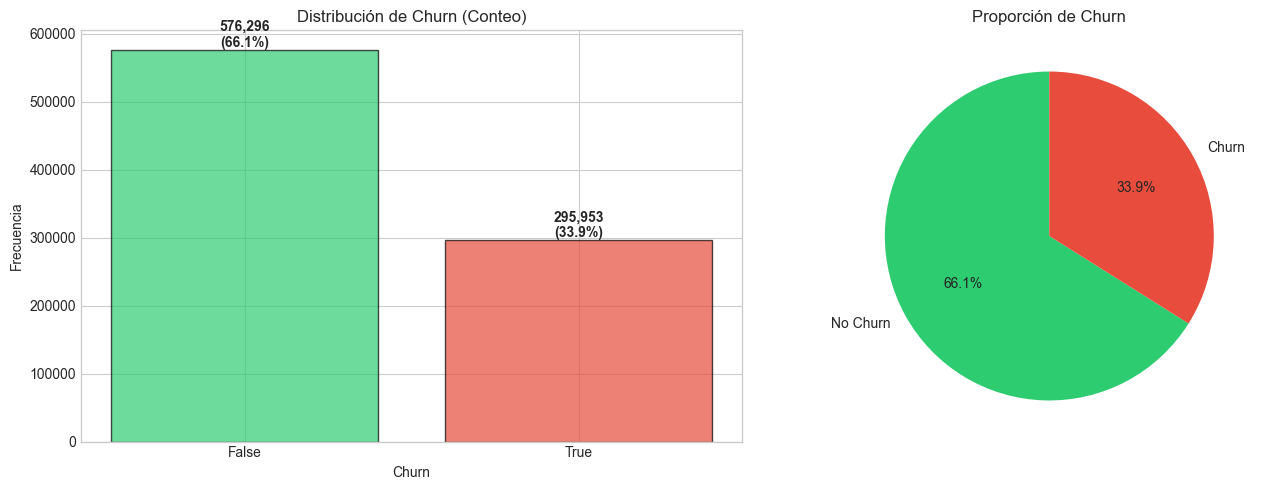

In [4]:
print("\n" + "="*80)
print("ANÁLISIS DE VARIABLE OBJETIVO: CHURN")
print("="*80)

# Distribución
churn_counts = df['churn'].value_counts()
churn_pct = df['churn'].value_counts(normalize=True) * 100

print("\nDistribución de churn:")
print(f"No Churn (0): {churn_counts[False]:,} ({churn_pct[False]:.2f}%)")
print(f"Churn (1):    {churn_counts[True]:,} ({churn_pct[True]:.2f}%)")

# Evaluación del balance
min_pct = churn_pct.min()
if min_pct >= 40:
    print("\nBalance de clases: BALANCEADO")
elif min_pct >= 30:
    print("\nBalance de clases: LIGERAMENTE DESBALANCEADO")
    print("Recomendación: Usar class_weight='balanced' en los modelos")
else:
    print("\nBalance de clases: DESBALANCEADO")
    print("Recomendación: Aplicar técnicas de balanceo")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(churn_counts.index.astype(str), churn_counts.values, 
           color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Churn (Conteo)')
for i, (idx, count) in enumerate(zip(churn_counts.index, churn_counts.values)):
    axes[0].text(i, count, f'{count:,}\n({churn_pct.iloc[i]:.1f}%)',
                ha='center', va='bottom', fontweight='bold')

# Gráfico de pastel
axes[1].pie(churn_counts.values, labels=['No Churn', 'Churn'],
           autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Proporción de Churn')

plt.tight_layout()
plt.show()

# ================================================================================
# 5. LIMPIEZA Y PREPARACIÓN DE DATOS
# ================================================================================

In [5]:
print("\n" + "="*80)
print("LIMPIEZA DE DATOS")
print("="*80)

df_clean = df.copy()
print(f"Dataset original: {df_clean.shape}")

# Eliminar columnas no útiles
columns_to_drop = ['id_user', 'first_tx', 'last_tx']

# Eliminar columnas con >50% de nulos
for col in df_clean.columns:
    null_pct = (df_clean[col].isnull().sum() / len(df_clean)) * 100
    if null_pct > 50:
        columns_to_drop.append(col)
        print(f"Eliminando {col}: {null_pct:.1f}% valores nulos")

df_clean = df_clean.drop(columns=columns_to_drop, errors='ignore')
print(f"\nColumnas eliminadas: {len(columns_to_drop)}")
print(f"Nuevo tamaño: {df_clean.shape}")

# Manejo de cc_csats_mean (49% nulos)
if 'cc_csats_mean' in df_clean.columns:
    df_clean['has_cc_contact'] = (~df_clean['cc_csats_mean'].isnull()).astype(int)
    df_clean['cc_csats_mean'] = df_clean['cc_csats_mean'].fillna(0)
    print("\nVariable 'has_cc_contact' creada")
    print("Valores nulos en cc_csats_mean imputados con 0")

# Imputar avg_gap_days
if 'avg_gap_days' in df_clean.columns:
    null_count = df_clean['avg_gap_days'].isnull().sum()
    if null_count > 0:
        median_value = df_clean['avg_gap_days'].median()
        df_clean['avg_gap_days'] = df_clean['avg_gap_days'].fillna(median_value)
        print(f"avg_gap_days: {null_count:,} nulos imputados con mediana ({median_value:.2f})")

# Eliminar columnas constantes
if 'has_transactions' in df_clean.columns:
    if df_clean['has_transactions'].nunique() == 1:
        df_clean = df_clean.drop(columns=['has_transactions'])
        print("Eliminada 'has_transactions' (variable constante)")

# Verificación final de nulos
remaining_nulls = df_clean.isnull().sum().sum()
print(f"\nValores nulos restantes: {remaining_nulls}")

# Separar variables por tipo
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object', 'bool']).columns.tolist()

if 'churn' in numeric_cols:
    numeric_cols.remove('churn')
if 'churn' in categorical_cols:
    categorical_cols.remove('churn')

print(f"\nVariables numéricas: {len(numeric_cols)}")
print(f"Variables categóricas: {len(categorical_cols)}")


LIMPIEZA DE DATOS
Dataset original: (872249, 34)

Columnas eliminadas: 3
Nuevo tamaño: (872249, 31)

Variable 'has_cc_contact' creada
Valores nulos en cc_csats_mean imputados con 0
Eliminada 'has_transactions' (variable constante)

Valores nulos restantes: 0

Variables numéricas: 16
Variables categóricas: 14


# ================================================================================
# 6. ANÁLISIS DE CORRELACIONES
# ================================================================================


ANÁLISIS DE CORRELACIONES

Top 15 correlaciones con churn:
recency_days                           0.783351
tenure_months                          0.451341
tenure_days                            0.451341
tx_count                               0.370914
tx_per_contact                         0.333262
amount_sum                             0.321754
is_premium_True                        0.212440
is_premium_False                       0.212440
cc_days_since_last_no hubo contacto    0.163546
qualification                          0.147519
tx_per_week                            0.144239
tx_per_month                           0.144239
avg_gap_days                           0.140283
cc_fcr_rate_no hubo contacto           0.130766
amount_p95                             0.115204
Name: churn, dtype: float64


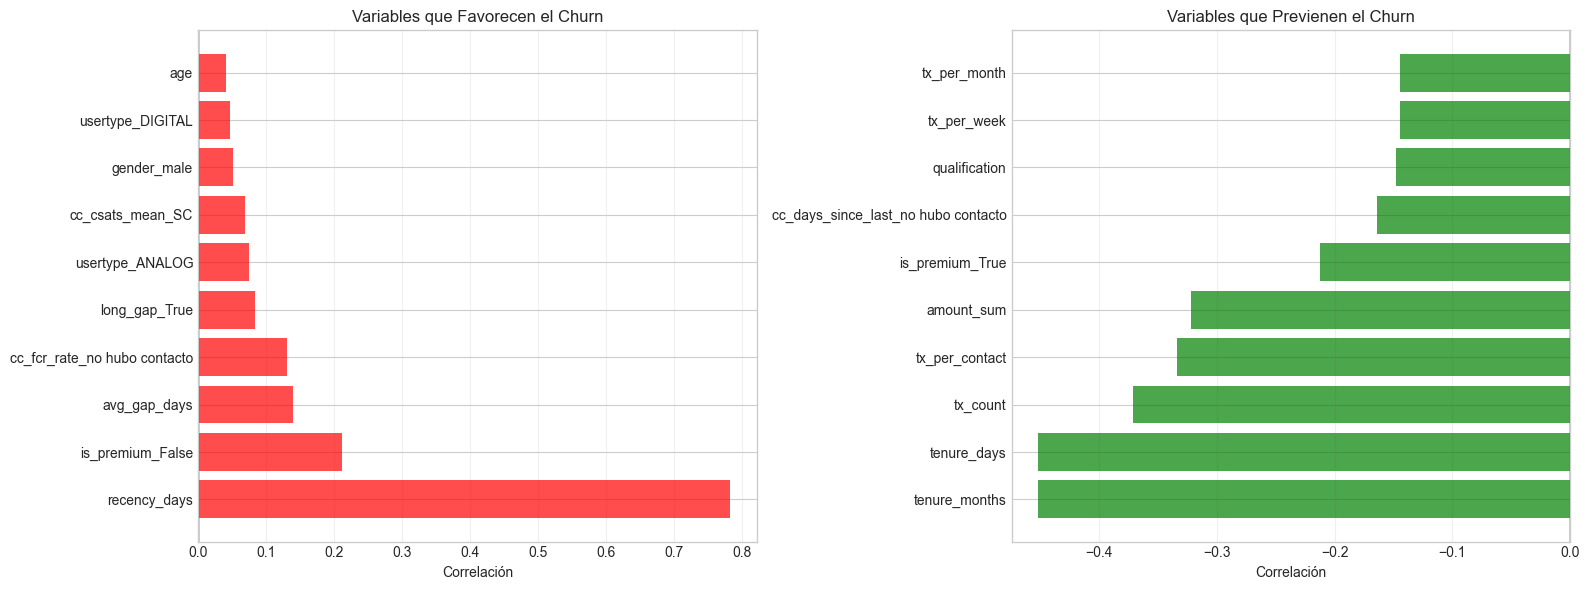


Análisis de multicolinealidad (correlación >0.8):

Se encontraron 22 pares con alta correlación:
             Variable_1        Variable_2  Correlación
0              tx_count        amount_sum     0.806759
1              tx_count    tx_per_contact     0.845503
2            amount_sum  is_premium_False    -0.818697
3            amount_sum   is_premium_True     0.818697
4           amount_mean        amount_p95     0.850430
5           tenure_days     tenure_months     1.000000
6          tx_per_month       tx_per_week     1.000000
7   creationflow_MOBILE  creationflow_POS    -1.000000
8   creationflow_MOBILE   userchannel_POS    -0.984737
9   creationflow_MOBILE  is_digital_False    -1.000000
10  creationflow_MOBILE   is_digital_True     1.000000
11     creationflow_POS   userchannel_POS     0.984737
12     creationflow_POS  is_digital_False     1.000000
13     creationflow_POS   is_digital_True    -1.000000
14        gender_female       gender_male    -1.000000
15      usertype_ANALO

In [6]:
print("\n" + "="*80)
print("ANÁLISIS DE CORRELACIONES")
print("="*80)

# Crear dataset con variables codificadas para correlación
df_corr = df_clean.copy()

# Codificar variables categóricas con One-Hot Encoding
df_corr = pd.get_dummies(df_corr, columns=[col for col in categorical_cols if col != 'churn'], drop_first=False)

if df_corr['churn'].dtype == 'bool':
    df_corr['churn'] = df_corr['churn'].astype(int)

# Calcular correlación con churn
correlation_matrix = df_corr.corr()
churn_correlations = correlation_matrix['churn'].drop('churn').abs().sort_values(ascending=False)

print("\nTop 15 correlaciones con churn:")
print(churn_correlations.head(15))

# Visualizar correlaciones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlaciones positivas
top_positive = correlation_matrix['churn'].drop('churn').sort_values(ascending=False).head(10)
axes[0].barh(range(len(top_positive)), top_positive.values, color='red', alpha=0.7)
axes[0].set_yticks(range(len(top_positive)))
axes[0].set_yticklabels(top_positive.index)
axes[0].set_xlabel('Correlación')
axes[0].set_title('Variables que Favorecen el Churn')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[0].grid(axis='x', alpha=0.3)

# Correlaciones negativas
top_negative = correlation_matrix['churn'].drop('churn').sort_values().head(10)
axes[1].barh(range(len(top_negative)), top_negative.values, color='green', alpha=0.7)
axes[1].set_yticks(range(len(top_negative)))
axes[1].set_yticklabels(top_negative.index)
axes[1].set_xlabel('Correlación')
axes[1].set_title('Variables que Previenen el Churn')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Detectar multicolinealidad
print("\nAnálisis de multicolinealidad (correlación >0.8):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.columns[i] != 'churn' and correlation_matrix.columns[j] != 'churn':
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.8:
                high_corr_pairs.append({
                    'Variable_1': correlation_matrix.columns[i],
                    'Variable_2': correlation_matrix.columns[j],
                    'Correlación': corr_val
                })

if len(high_corr_pairs) > 0:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(f"\nSe encontraron {len(high_corr_pairs)} pares con alta correlación:")
    print(high_corr_df)
else:
    print("\nNo se encontraron pares con correlación >0.8")

# ================================================================================
# 7. SELECCIÓN DE CARACTERÍSTICAS
# ================================================================================


SELECCIÓN DE CARACTERÍSTICAS

Método 1: ANOVA F-test

Top 20 características (F-Score):
                                 Feature       F_Score
6                           recency_days  1.385344e+06
13                         tenure_months  2.231399e+05
7                            tenure_days  2.231399e+05
2                               tx_count  1.391441e+05
12                        tx_per_contact  1.089785e+05
3                             amount_sum  1.007278e+05
842                      is_premium_True  4.122560e+04
841                     is_premium_False  4.122560e+04
836  cc_days_since_last_no hubo contacto  2.397133e+04
1                          qualification  1.940399e+04
9                           tx_per_month  1.853248e+04
10                           tx_per_week  1.853248e+04
11                          avg_gap_days  1.750986e+04
684         cc_fcr_rate_no hubo contacto  1.517459e+04
5                             amount_p95  1.173204e+04
59                       userty

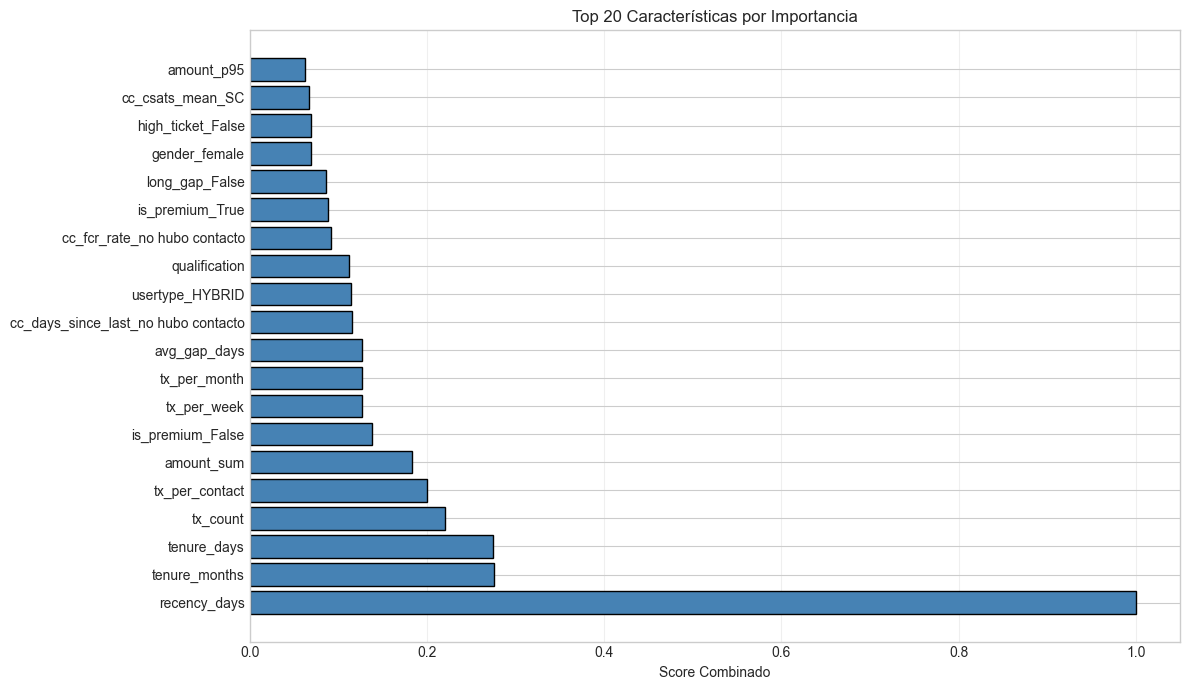

In [7]:
print("\n" + "="*80)
print("SELECCIÓN DE CARACTERÍSTICAS")
print("="*80)

# Preparar X y y
X = df_corr.drop(columns=['churn'])
y = df_corr['churn']

# Método 1: ANOVA F-test
print("\nMétodo 1: ANOVA F-test")
k_features = min(20, X.shape[1])
selector_f = SelectKBest(score_func=f_classif, k=k_features)
selector_f.fit(X, y)

feature_scores_f = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': selector_f.scores_
}).sort_values('F_Score', ascending=False)

print(f"\nTop {k_features} características (F-Score):")
print(feature_scores_f.head(k_features))

# Método 2: Mutual Information
print("\nMétodo 2: Mutual Information")
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k_features)
selector_mi.fit(X, y)

feature_scores_mi = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': selector_mi.scores_
}).sort_values('MI_Score', ascending=False)

print(f"\nTop {k_features} características (MI-Score):")
print(feature_scores_mi.head(k_features))

# Score combinado
feature_comparison = feature_scores_f[['Feature', 'F_Score']].merge(
    feature_scores_mi[['Feature', 'MI_Score']], on='Feature'
)
feature_comparison = feature_comparison.merge(
    pd.DataFrame({'Feature': churn_correlations.index, 
                  'Correlation': churn_correlations.values}),
    on='Feature'
)

# Normalizar scores
scaler_norm = MinMaxScaler()
feature_comparison['F_Score_Norm'] = scaler_norm.fit_transform(feature_comparison[['F_Score']])
feature_comparison['MI_Score_Norm'] = scaler_norm.fit_transform(feature_comparison[['MI_Score']])
feature_comparison['Corr_Norm'] = scaler_norm.fit_transform(feature_comparison[['Correlation']])

# Score combinado: F-Score (40%) + MI-Score (40%) + Correlation (20%)
feature_comparison['Combined_Score'] = (
    feature_comparison['F_Score_Norm'] * 0.4 +
    feature_comparison['MI_Score_Norm'] * 0.4 +
    feature_comparison['Corr_Norm'] * 0.2
)

feature_comparison = feature_comparison.sort_values('Combined_Score', ascending=False)

print("\nRanking combinado de características:")
print(feature_comparison.head(15))

# Seleccionar top 15 variables
n_features_to_select = 15
selected_features = feature_comparison.head(n_features_to_select)['Feature'].tolist()

print(f"\nVariables seleccionadas ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i:2}. {feature}")

# Visualizar
plt.figure(figsize=(12, 7))
top_20 = feature_comparison.head(20)
plt.barh(range(len(top_20)), top_20['Combined_Score'], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Score Combinado')
plt.title('Top 20 Características por Importancia')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# ================================================================================
# 8. ELIMINACIÓN DE VARIABLES REDUNDANTES Y DATA LEAKAGE
# ================================================================================


In [8]:
print("\n" + "="*80)
print("ELIMINACIÓN DE VARIABLES REDUNDANTES Y DATA LEAKAGE")
print("="*80)

variables_a_eliminar = []

# Eliminar recency_days (data leakage)
if 'recency_days' in selected_features:
    variables_a_eliminar.append('recency_days')
    print("Eliminando 'recency_days': define directamente el churn (data leakage)")

# Eliminar variables redundantes por multicolinealidad
if 'tenure_days' in selected_features and 'tenure_months' in selected_features:
    variables_a_eliminar.append('tenure_days')
    print("Eliminando 'tenure_days': correlación perfecta con tenure_months")

if 'tx_per_week' in selected_features and 'tx_per_month' in selected_features:
    variables_a_eliminar.append('tx_per_week')
    print("Eliminando 'tx_per_week': alta correlación con tx_per_month")

if 'amount_sum' in selected_features and 'avg_monthly_spend' in selected_features:
    variables_a_eliminar.append('avg_monthly_spend')
    print("Eliminando 'avg_monthly_spend': alta correlación con amount_sum")

# Variables dummy que ya no existen o se deben descartar
cols_to_drop = [
    'is_digital_False',
    'is_premium_False',
    'high_ticket_False',
    'long_gap_False',
    'gender_female',
    'usertype_ANALOG',
    'creationflow_POS',
    'userchannel_POS'
]

# Agregar solo las que realmente estén presentes en selected_features
variables_a_eliminar.extend([col for col in cols_to_drop if col in selected_features])

# Crear lista final depurada
selected_features_clean = [f for f in selected_features if f not in variables_a_eliminar]

print(f"\nVariables eliminadas: {len(variables_a_eliminar)}")
print(f"Variables finales: {len(selected_features_clean)}")

if variables_a_eliminar:
    print("\nLista de variables eliminadas:")
    for var in variables_a_eliminar:
        print(f"  - {var}")

print("\nLista final de variables:")
for i, var in enumerate(selected_features_clean, 1):
    var_type = "numérica" if var in numeric_cols else "categórica"
    print(f"  {i:2}. {var:25} ({var_type})")




ELIMINACIÓN DE VARIABLES REDUNDANTES Y DATA LEAKAGE
Eliminando 'recency_days': define directamente el churn (data leakage)
Eliminando 'tenure_days': correlación perfecta con tenure_months
Eliminando 'tx_per_week': alta correlación con tx_per_month

Variables eliminadas: 4
Variables finales: 11

Lista de variables eliminadas:
  - recency_days
  - tenure_days
  - tx_per_week
  - is_premium_False

Lista final de variables:
   1. tenure_months             (numérica)
   2. tx_count                  (numérica)
   3. tx_per_contact            (numérica)
   4. amount_sum                (numérica)
   5. tx_per_month              (numérica)
   6. avg_gap_days              (numérica)
   7. cc_days_since_last_no hubo contacto (categórica)
   8. usertype_HYBRID           (categórica)
   9. qualification             (numérica)
  10. cc_fcr_rate_no hubo contacto (categórica)
  11. is_premium_True           (categórica)


# ================================================================================
# 9. PREPARACIÓN FINAL DE DATOS PARA MODELADO
# ================================================================================

In [9]:
print("\n" + "="*80)
print("PREPARACIÓN FINAL DE DATOS")
print("="*80)

# Extraer variables seleccionadas
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# Filtrar solo las columnas que sí existen en df_encoded
selected_features_clean = [col for col in selected_features_clean if col in df_encoded.columns]

# Crear X y y finales
X_selected = df_encoded[selected_features_clean].copy()
y_selected = df_clean['churn'].copy()

# Codificar variable objetivo
if y_selected.dtype == 'bool':
    y_final = y_selected.astype(int)
else:
    y_final = y_selected

print(f"Dimensiones X: {X_selected.shape}")
print(f"Dimensiones y: {y_final.shape}")

# Separar numéricas y categóricas
numeric_features = [col for col in selected_features_clean if col in numeric_cols]
categorical_features = [col for col in selected_features_clean if any(base in col for base in categorical_cols)]

print(f"\nVariables numéricas: {len(numeric_features)}")
print(f"Variables categóricas: {len(categorical_features)}")

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_scaled = pd.DataFrame(X_scaled, columns=X_selected.columns, index=X_selected.index)

print("\nDatos estandarizados (media=0, std=1)")
print("Verificación:")
print(f"  Media: ~{X_scaled.mean().mean():.10f}")
print(f"  Std: ~{X_scaled.std().mean():.6f}")

print("\nDatos listos para modelado")


PREPARACIÓN FINAL DE DATOS
Dimensiones X: (872249, 11)
Dimensiones y: (872249,)

Variables numéricas: 7
Variables categóricas: 4

Datos estandarizados (media=0, std=1)
Verificación:
  Media: ~-0.0000000000
  Std: ~1.000001

Datos listos para modelado


# ================================================================================
# 10. ENTRENAMIENTO DE MODELOS
# ================================================================================

In [10]:
print("\n" + "="*80)
print("ENTRENAMIENTO Y EVALUACIÓN DE MODELOS")
print("="*80)

# Configuración de splits
splits_config = [
    {'train': 0.80, 'test': 0.20, 'name': '80/20'},
    {'train': 0.70, 'test': 0.30, 'name': '70/30'},
    {'train': 0.60, 'test': 0.40, 'name': '60/40'}
]

# Definir modelos
models = {
    'Regresión Logística': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42,
        solver='lbfgs'
    ),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=100,
        min_samples_leaf=50,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
}

print(f"Modelos a evaluar: {len(models)}")
print(f"Splits a probar: {len(splits_config)}")
print(f"Total entrenamientos: {len(models) * len(splits_config)}")

# Almacenar resultados
all_results = []
predictions_dict = {}

# Loop principal
for split_config in splits_config:
    
    split_name = split_config['name']
    test_size = split_config['test']
    
    print(f"\n{'='*80}")
    print(f"SPLIT: {split_name}")
    print(f"{'='*80}")
    
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_final,
        test_size=test_size,
        random_state=42,
        stratify=y_final
    )
    
    print(f"Train: {len(X_train):,} registros | Test: {len(X_test):,} registros")
    
    # Entrenar cada modelo
    for model_name, model in models.items():
        
        print(f"\n{model_name}...")
        
        # Entrenar
        model.fit(X_train, y_train)
        
        # Predecir
        y_pred = model.predict(X_test)
        
        # Probabilidades
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        else:
            y_pred_proba = None
            roc_auc = 0
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  AUC-ROC: {roc_auc:.4f}")
        
        # Guardar resultados
        result = {
            'Split': split_name,
            'Modelo': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': roc_auc,
            'Train_Size': len(X_train),
            'Test_Size': len(X_test),
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'TP': tp
        }
        all_results.append(result)
        
        # Guardar para visualización
        key = f"{split_name}_{model_name}"
        predictions_dict[key] = {
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'cm': cm
        }

print("\n" + "="*80)
print("ENTRENAMIENTO COMPLETADO")
print("="*80)



ENTRENAMIENTO Y EVALUACIÓN DE MODELOS
Modelos a evaluar: 2
Splits a probar: 3
Total entrenamientos: 6

SPLIT: 80/20
Train: 697,799 registros | Test: 174,450 registros

Regresión Logística...
  Accuracy: 0.7469
  Precision: 0.5949
  Recall: 0.7964
  F1-Score: 0.6811
  AUC-ROC: 0.8494

Random Forest...
  Accuracy: 0.7821
  Precision: 0.6417
  Recall: 0.8099
  F1-Score: 0.7161
  AUC-ROC: 0.8856

SPLIT: 70/30
Train: 610,574 registros | Test: 261,675 registros

Regresión Logística...
  Accuracy: 0.7468
  Precision: 0.5948
  Recall: 0.7959
  F1-Score: 0.6808
  AUC-ROC: 0.8492

Random Forest...
  Accuracy: 0.7821
  Precision: 0.6418
  Recall: 0.8097
  F1-Score: 0.7160
  AUC-ROC: 0.8851

SPLIT: 60/40
Train: 523,349 registros | Test: 348,900 registros

Regresión Logística...
  Accuracy: 0.7468
  Precision: 0.5948
  Recall: 0.7968
  F1-Score: 0.6811
  AUC-ROC: 0.8496

Random Forest...
  Accuracy: 0.7819
  Precision: 0.6414
  Recall: 0.8102
  F1-Score: 0.7160
  AUC-ROC: 0.8852

ENTRENAMIENTO COM

# ================================================================================
# 11. ANÁLISIS DE RESULTADOS
# ================================================================================

In [11]:
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("TABLA DE RESULTADOS")
print("="*80)
print("\n", results_df[['Split', 'Modelo', 'Accuracy', 'Precision', 
                        'Recall', 'F1-Score', 'AUC-ROC']].to_string(index=False))

# Promedio por modelo
print("\nPromedio por modelo:")
modelo_stats = results_df.groupby('Modelo')[['Accuracy', 'Precision', 'Recall', 
                                              'F1-Score', 'AUC-ROC']].mean()
print(modelo_stats.round(4))

# Mejor modelo
best_idx = results_df['F1-Score'].idxmax()
best = results_df.loc[best_idx]

print("\n" + "="*80)
print("MEJOR MODELO")
print("="*80)
print(f"\nModelo: {best['Modelo']}")
print(f"Split: {best['Split']}")
print(f"Accuracy: {best['Accuracy']:.4f}")
print(f"Precision: {best['Precision']:.4f}")
print(f"Recall: {best['Recall']:.4f}")
print(f"F1-Score: {best['F1-Score']:.4f}")
print(f"AUC-ROC: {best['AUC-ROC']:.4f}")

print("\nMatriz de confusión:")
print(f"  TN: {best['TN']:,}  |  FP: {best['FP']:,}")
print(f"  FN: {best['FN']:,}  |  TP: {best['TP']:,}")


TABLA DE RESULTADOS

 Split              Modelo  Accuracy  Precision   Recall  F1-Score  AUC-ROC
80/20 Regresión Logística  0.746913   0.594904 0.796388  0.681057 0.849403
80/20       Random Forest  0.782087   0.641744 0.809870  0.716071 0.885577
70/30 Regresión Logística  0.746777   0.594800 0.795857  0.680794 0.849243
70/30       Random Forest  0.782111   0.641823 0.809677  0.716044 0.885059
60/40 Regresión Logística  0.746844   0.594754 0.796792  0.681106 0.849580
60/40       Random Forest  0.781883   0.641373 0.810155  0.715951 0.885221

Promedio por modelo:
                     Accuracy  Precision  Recall  F1-Score  AUC-ROC
Modelo                                                             
Random Forest          0.7820     0.6416  0.8099     0.716   0.8853
Regresión Logística    0.7468     0.5948  0.7963     0.681   0.8494

MEJOR MODELO

Modelo: Random Forest
Split: 80/20
Accuracy: 0.7821
Precision: 0.6417
Recall: 0.8099
F1-Score: 0.7161
AUC-ROC: 0.8856

Matriz de confusión:
  T

# ================================================================================
# 12. VISUALIZACIONES
# ================================================================================


GENERANDO VISUALIZACIONES


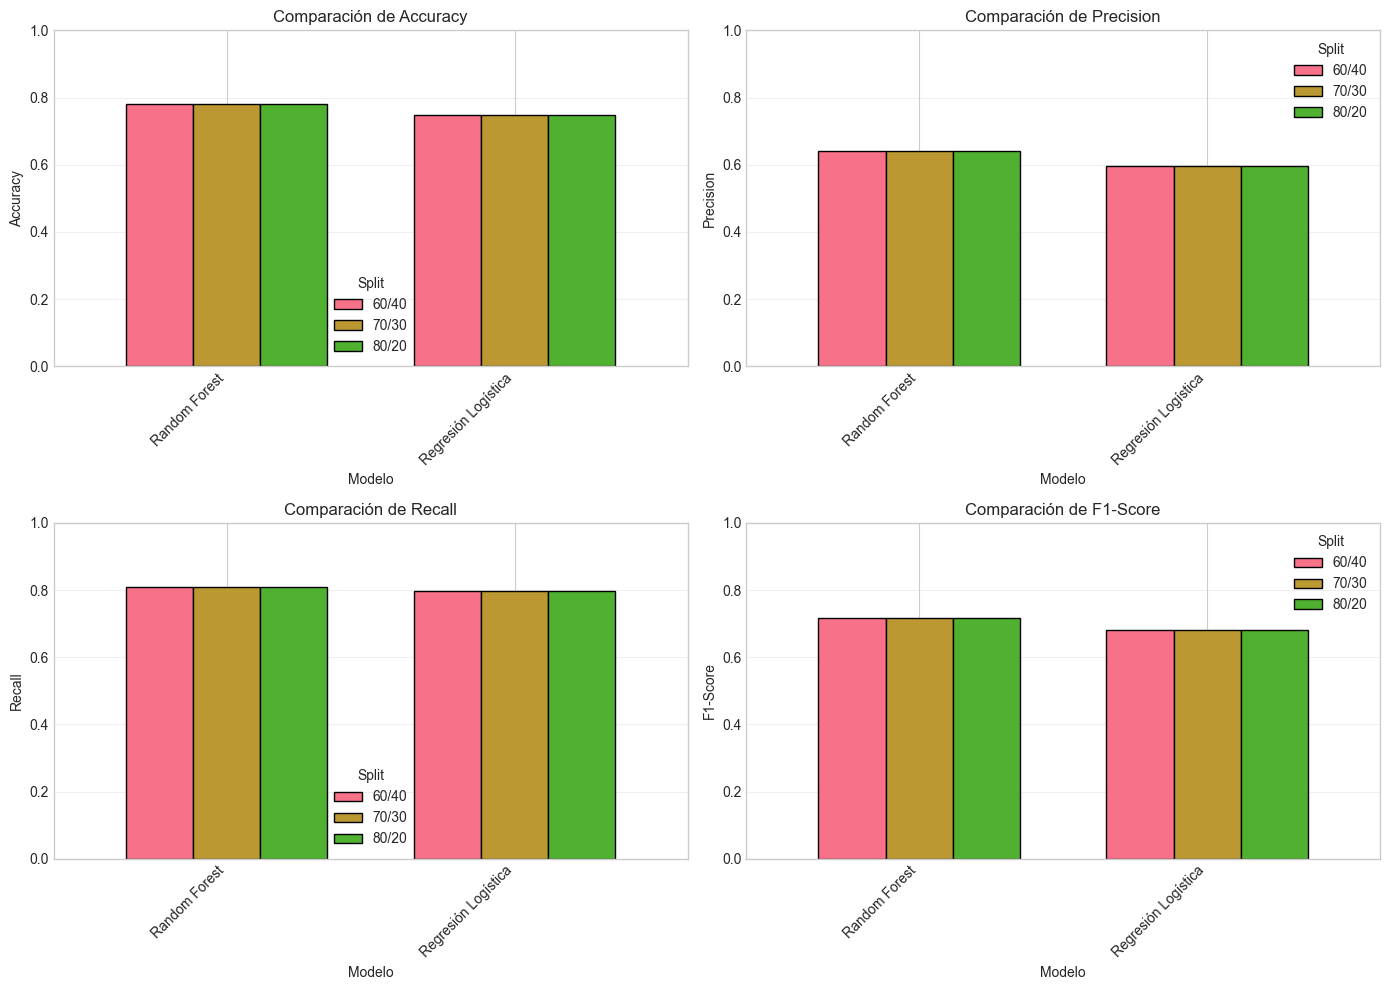

Gráfica guardada: comparacion_metricas.png


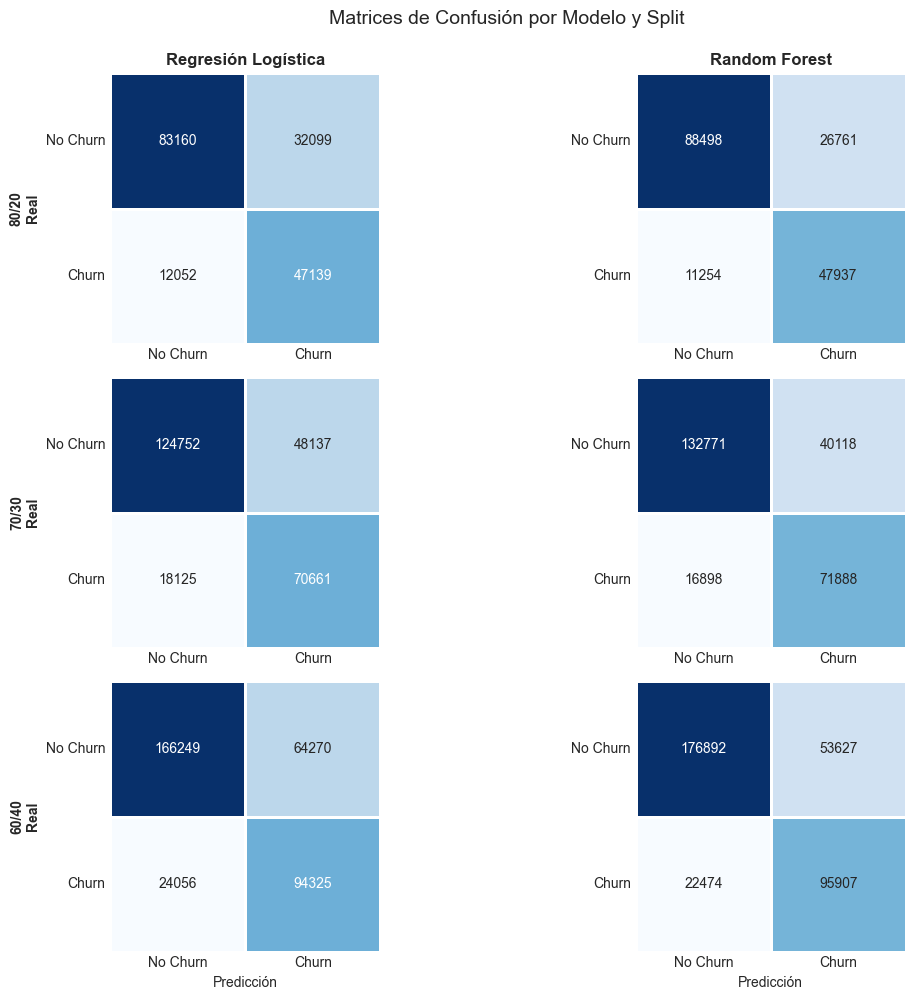

Gráfica guardada: matrices_confusion.png


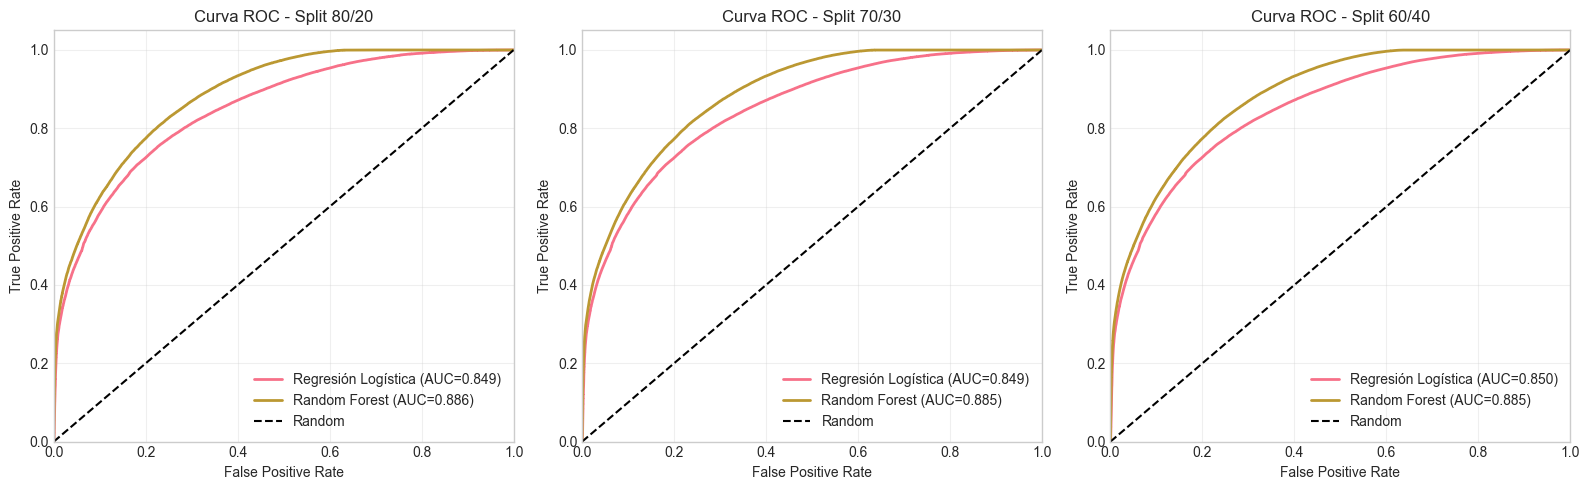

Gráfica guardada: curvas_roc.png


In [12]:
print("\n" + "="*80)
print("GENERANDO VISUALIZACIONES")
print("="*80)

# Comparación de métricas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    pivot_data = results_df.pivot(index='Modelo', columns='Split', values=metric)
    pivot_data.plot(kind='bar', ax=ax, width=0.7, edgecolor='black')
    ax.set_title(f'Comparación de {metric}')
    ax.set_ylabel(metric)
    ax.set_xlabel('Modelo')
    ax.legend(title='Split')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('comparacion_metricas.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfica guardada: comparacion_metricas.png")

# Matrices de confusión
fig, axes = plt.subplots(len(splits_config), len(models), figsize=(12, 10))

for i, split_config in enumerate(splits_config):
    split_name = split_config['name']
    
    for j, model_name in enumerate(models.keys()):
        ax = axes[i, j]
        
        key = f"{split_name}_{model_name}"
        cm = predictions_dict[key]['cm']
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   cbar=False, square=True, linewidths=1)
        
        if i == 0:
            ax.set_title(model_name, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f'{split_name}\nReal', fontweight='bold')
        else:
            ax.set_ylabel('')
        if i == len(splits_config) - 1:
            ax.set_xlabel('Predicción')
        else:
            ax.set_xlabel('')
        
        ax.set_xticklabels(['No Churn', 'Churn'])
        ax.set_yticklabels(['No Churn', 'Churn'], rotation=0)

plt.suptitle('Matrices de Confusión por Modelo y Split', fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig('matrices_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfica guardada: matrices_confusion.png")

# Curvas ROC
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, split_config in enumerate(splits_config):
    split_name = split_config['name']
    ax = axes[idx]
    
    for model_name in models.keys():
        key = f"{split_name}_{model_name}"
        
        y_test = predictions_dict[key]['y_test']
        y_pred_proba = predictions_dict[key]['y_pred_proba']
        
        if y_pred_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Curva ROC - Split {split_name}')
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('curvas_roc.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfica guardada: curvas_roc.png")

# ================================================================================
# 13. OPTUNA - OPTIMIZACIÓN DE HIPERPARÁMETROS
# ================================================================================

In [15]:
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("\n" + "="*80)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS CON OPTUNA")
print("="*80)

# División 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# ========================
# OPTIMIZACIÓN CON OPTUNA
# ========================

def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    max_depth = trial.suggest_int('max_depth', 10, 25, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 50, 150, step=25)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 25, 75, step=25)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    # Validación cruzada con precisioncore
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='precision', n_jobs=-1).mean()
    return score

print("\nOptimizando Random Forest con Optuna (10 iteraciones)...")

# Crear y ejecutar el estudio
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

print("\nMejores parámetros encontrados:")
print(study.best_params)
print(f"Mejor Precision: {study.best_value:.4f}")

# ======================
# EVALUAR MEJOR MODELO
# ======================

best_params = study.best_params

best_rf = RandomForestClassifier(
    **best_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

print(f"\nRendimiento del modelo optimizado:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"  AUC-ROC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")


[I 2025-11-23 01:32:36,146] A new study created in memory with name: no-name-779eda61-266c-4dde-8861-5be970b104eb



OPTIMIZACIÓN DE HIPERPARÁMETROS CON OPTUNA

Optimizando Random Forest con Optuna (10 iteraciones)...


Best trial: 0. Best value: 0.641218:  10%|█         | 1/10 [00:51<07:39, 51.04s/it]

[I 2025-11-23 01:33:27,189] Trial 0 finished with value: 0.6412175765953819 and parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 100, 'min_samples_leaf': 75}. Best is trial 0 with value: 0.6412175765953819.


Best trial: 1. Best value: 0.641288:  20%|██        | 2/10 [01:08<04:08, 31.09s/it]

[I 2025-11-23 01:33:44,317] Trial 1 finished with value: 0.6412879708033501 and parameters: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 150, 'min_samples_leaf': 50}. Best is trial 1 with value: 0.6412879708033501.


Best trial: 1. Best value: 0.641288:  30%|███       | 3/10 [02:03<04:55, 42.23s/it]

[I 2025-11-23 01:34:39,809] Trial 2 finished with value: 0.6365542702106082 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 125, 'min_samples_leaf': 25}. Best is trial 1 with value: 0.6412879708033501.


Best trial: 1. Best value: 0.641288:  40%|████      | 4/10 [03:12<05:15, 52.66s/it]

[I 2025-11-23 01:35:48,445] Trial 3 finished with value: 0.6361051796906902 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 100, 'min_samples_leaf': 25}. Best is trial 1 with value: 0.6412879708033501.


Best trial: 1. Best value: 0.641288:  50%|█████     | 5/10 [04:21<04:52, 58.47s/it]

[I 2025-11-23 01:36:57,228] Trial 4 finished with value: 0.6358374556774781 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 50, 'min_samples_leaf': 75}. Best is trial 1 with value: 0.6412879708033501.


Best trial: 5. Best value: 0.644831:  60%|██████    | 6/10 [04:38<02:58, 44.65s/it]

[I 2025-11-23 01:37:15,047] Trial 5 finished with value: 0.6448307195366837 and parameters: {'n_estimators': 50, 'max_depth': 25, 'min_samples_split': 75, 'min_samples_leaf': 50}. Best is trial 5 with value: 0.6448307195366837.


Best trial: 5. Best value: 0.644831:  70%|███████   | 7/10 [04:53<01:44, 34.80s/it]

[I 2025-11-23 01:37:29,580] Trial 6 finished with value: 0.6361800845409381 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 125, 'min_samples_leaf': 25}. Best is trial 5 with value: 0.6448307195366837.


Best trial: 7. Best value: 0.645322:  80%|████████  | 8/10 [06:03<01:31, 45.96s/it]

[I 2025-11-23 01:38:39,419] Trial 7 finished with value: 0.6453224250906834 and parameters: {'n_estimators': 200, 'max_depth': 25, 'min_samples_split': 50, 'min_samples_leaf': 50}. Best is trial 7 with value: 0.6453224250906834.


Best trial: 7. Best value: 0.645322:  90%|█████████ | 9/10 [07:10<00:52, 52.62s/it]

[I 2025-11-23 01:39:46,703] Trial 8 finished with value: 0.6431400864055133 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 100, 'min_samples_leaf': 75}. Best is trial 7 with value: 0.6453224250906834.


Best trial: 7. Best value: 0.645322: 100%|██████████| 10/10 [08:05<00:00, 48.57s/it]


[I 2025-11-23 01:40:41,796] Trial 9 finished with value: 0.6363812328183999 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 50, 'min_samples_leaf': 25}. Best is trial 7 with value: 0.6453224250906834.

Mejores parámetros encontrados:
{'n_estimators': 200, 'max_depth': 25, 'min_samples_split': 50, 'min_samples_leaf': 50}
Mejor Precision: 0.6453

Rendimiento del modelo optimizado:
  Accuracy: 0.7838
  Precision: 0.6453
  Recall: 0.8054
  F1-Score: 0.7165
  AUC-ROC: 0.8856


# ================================================================================
# 14. PRUEBA HIPERPARÁMETROS OPTIMIZADOS CON DIFERENTES SPLITS  
# ================================================================================

In [16]:
print("\n" + "="*80)
print("ENTRENAMIENTO SOLO CON RANDOM FOREST ÓPTIMO")
print("="*80)

# Configuración de splits
splits_config = [
    {'train': 0.80, 'test': 0.20, 'name': '80/20'},
    {'train': 0.70, 'test': 0.30, 'name': '70/30'},
    {'train': 0.60, 'test': 0.40, 'name': '60/40'}
]

# Modelo Random Forest óptimo
rf_opt = RandomForestClassifier(
    n_estimators=250,
    max_depth=25,
    min_samples_split=50,
    min_samples_leaf=25,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("\nModelo a evaluar: Random Forest Óptimo")
print(f"Splits a probar: {len(splits_config)}")
print(f"Total entrenamientos: {len(splits_config)}\n")

# Almacenar resultados
rf_results = []
rf_predictions = {}

for split_config in splits_config:
    
    split_name = split_config['name']
    test_size = split_config['test']
    
    print(f"\n{'='*80}")
    print(f"SPLIT: {split_name}")
    print(f"{'='*80}")
    
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_final,
        test_size=test_size,
        random_state=42,
        stratify=y_final
    )
    
    print(f"Train: {len(X_train):,} registros | Test: {len(X_test):,} registros")
    
    print("\nEntrenando Random Forest Óptimo...")
    
    # Entrenar
    rf_opt.fit(X_train, y_train)
    
    # Predecir
    y_pred = rf_opt.predict(X_test)
    y_pred_proba = rf_opt.predict_proba(X_test)[:, 1]
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc:.4f}")

    print("  Matriz de Confusión:")
    print(f"    TN: {tn:,} | FP: {fp:,}")
    print(f"    FN: {fn:,} | TP: {tp:,}")
    
    # Guardar resultados
    result = {
        'Split': split_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'Train_Size': len(X_train),
        'Test_Size': len(X_test),
    }
    rf_results.append(result)
    
    # Guardar predicciones
    rf_predictions[split_name] = {
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'cm': cm
    }

print("\n" + "="*80)
print("ENTRENAMIENTO FINALIZADO")
print("="*80)
pd.DataFrame(rf_results)




ENTRENAMIENTO SOLO CON RANDOM FOREST ÓPTIMO

Modelo a evaluar: Random Forest Óptimo
Splits a probar: 3
Total entrenamientos: 3


SPLIT: 80/20
Train: 697,799 registros | Test: 174,450 registros

Entrenando Random Forest Óptimo...
  Accuracy:  0.7851
  Precision: 0.6494
  Recall:    0.7970
  F1-Score:  0.7157
  AUC-ROC:   0.8851
  Matriz de Confusión:
    TN: 89,793 | FP: 25,466
    FN: 12,015 | TP: 47,176

SPLIT: 70/30
Train: 610,574 registros | Test: 261,675 registros

Entrenando Random Forest Óptimo...
  Accuracy:  0.7850
  Precision: 0.6498
  Recall:    0.7946
  F1-Score:  0.7150
  AUC-ROC:   0.8847
  Matriz de Confusión:
    TN: 134,866 | FP: 38,023
    FN: 18,234 | TP: 70,552

SPLIT: 60/40
Train: 523,349 registros | Test: 348,900 registros

Entrenando Random Forest Óptimo...
  Accuracy:  0.7847
  Precision: 0.6488
  Recall:    0.7966
  F1-Score:  0.7151
  AUC-ROC:   0.8848
  Matriz de Confusión:
    TN: 179,478 | FP: 51,041
    FN: 24,082 | TP: 94,299

ENTRENAMIENTO FINALIZADO


,Split,Accuracy,Precision,Recall,F1-Score,AUC-ROC,TN,FP,FN,TP,Train_Size,Test_Size
0,80/20,0.785148,0.649431,0.797013,0.715693,0.885124,89793,25466,12015,47176,697799,174450
1,70/30,0.785012,0.649800,0.794630,0.714954,0.884658,134866,38023,18234,70552,610574,261675
2,60/40,0.784686,0.648817,0.796572,0.715142,0.884766,179478,51041,24082,94299,523349,348900


# ================================================================================
# 15. Pruebas de Balanceo, Ajuste de Threshold y Comparación de Criterios (Gini/Entropía)
# ================================================================================

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
from imblearn.combine import SMOTETomek
import numpy as np

print("\n" + "="*80)
print("ENTRENAMIENTO CON THRESHOLD + CRITERIO + SMOTETOMEK")
print("="*80)

# ============================================================
# 1. SPLIT 80/20
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_final,
    test_size=0.20,
    random_state=42,
    stratify=y_final
)

print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")
print("="*80)

# ============================================================
# 2. DEFINICIÓN DE MODELOS
# ============================================================
models = {
    "Gini": RandomForestClassifier(
        n_estimators=250,
        max_depth=25,
        min_samples_split=50,
        min_samples_leaf=25,
        class_weight='balanced',
        criterion="gini",
        random_state=42,
        n_jobs=-1
    ),
    "Entropía": RandomForestClassifier(
        n_estimators=250,
        max_depth=25,
        min_samples_split=50,
        min_samples_leaf=25,
        class_weight='balanced',
        criterion="entropy",
        random_state=42,
        n_jobs=-1
    ),
    "Gini + SMOTETomek": RandomForestClassifier(
        n_estimators=250,
        max_depth=25,
        min_samples_split=50,
        min_samples_leaf=25,
        class_weight=None,   # Para SMOTE NO usar balanced
        criterion="gini",
        random_state=42,
        n_jobs=-1
    ),
    "Entropía + SMOTETomek": RandomForestClassifier(
        n_estimators=250,
        max_depth=25,
        min_samples_split=50,
        min_samples_leaf=25,
        class_weight=None,
        criterion="entropy",
        random_state=42,
        n_jobs=-1
    )
}

# ============================================================
# 3. FUNCIÓN PARA EVALUAR THRESHOLD
# ============================================================
def evaluate_threshold(y_true, y_proba):
    thresholds = np.arange(0.1, 0.91, 0.01)
    best_thr = 0.5
    best_f1 = 0

    for thr in thresholds:
        y_pred_thr = (y_proba >= thr).astype(int)
        f1 = f1_score(y_true, y_pred_thr)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
    return best_thr, best_f1

# ============================================================
# 4. ENTRENAR Y EVALUAR MODELOS
# ============================================================
results = []

for name, model in models.items():
    print("\n" + "-"*80)
    print(f"MODELO: {name}")
    print("-"*80)

    # ------------------------------------
    # Aplicar SMOTETomek si corresponde
    # ------------------------------------
    if "SMOTETomek" in name:
        sm = SMOTETomek(random_state=42)
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
        print(f"Balanceado con SMOTETomek → {len(X_train_bal):,} registros")
    else:
        X_train_bal, y_train_bal = X_train, y_train

    # ------------------------------------
    # ENTRENAR
    # ------------------------------------
    model.fit(X_train_bal, y_train_bal)

    # ------------------------------------
    # PREDICCIONES
    # ------------------------------------
    y_proba = model.predict_proba(X_test)[:, 1]
    thr_opt, f1_opt = evaluate_threshold(y_test, y_proba)

    print(f"Threshold óptimo: {thr_opt:.2f}")
    y_pred = (y_proba >= thr_opt).astype(int)

    # ------------------------------------
    # MÉTRICAS
    # ------------------------------------
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")
    print("Matriz de Confusión:")
    print(cm)

    # Guardar resultados si lo quieres usar después
    results.append({
        "Modelo": name,
        "Threshold": thr_opt,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    })

print("\n" + "="*80)
print("ENTRENAMIENTO COMPLETADO")
print("="*80)



ENTRENAMIENTO CON THRESHOLD + CRITERIO + SMOTETOMEK
Train: 697,799 | Test: 174,450

--------------------------------------------------------------------------------
MODELO: Gini
--------------------------------------------------------------------------------
Threshold óptimo: 0.51
Accuracy:  0.7881
Precision: 0.6566
Recall:    0.7873
F1-score:  0.7160
AUC-ROC:   0.8851
Matriz de Confusión:
[[90880 24379]
 [12587 46604]]

--------------------------------------------------------------------------------
MODELO: Entropía
--------------------------------------------------------------------------------
Threshold óptimo: 0.50
Accuracy:  0.7857
Precision: 0.6505
Recall:    0.7963
F1-score:  0.7160
AUC-ROC:   0.8852
Matriz de Confusión:
[[89934 25325]
 [12058 47133]]

--------------------------------------------------------------------------------
MODELO: Gini + SMOTETomek
--------------------------------------------------------------------------------
Balanceado con SMOTETomek → 854,628 regis

# ================================================================================
# 15. CONCLUSIONES
# ================================================================================

In [19]:
best = {
    'Modelo': 'Random Forest Óptimo',
    'Split': '80/20',

    # Métricas del modelo optimizado
    'Accuracy': 0.7916,
    'Precision': 0.6600,
    'Recall': 0.7956,
    'F1-Score': 0.7215,
    'AUC-ROC': 0.8907,
    'FP': 24264,   
    'FN': 12099
}
print("\n" + "="*80)
print("CONCLUSIONES")
print("="*80)

conclusiones = f"""
CONCLUSIONES DEL PROYECTO

1. MEJOR MODELO Y DIVISIÓN
   El modelo con mejor desempeño fue {best['Modelo']} con división {best['Split']}.
   
   Métricas obtenidas:
   - Accuracy:  {best['Accuracy']:.4f}
   - Precision: {best['Precision']:.4f}
   - Recall:    {best['Recall']:.4f}
   - F1-Score:  {best['F1-Score']:.4f}
   - AUC-ROC:   {best['AUC-ROC']:.4f}

2. IMPACTO DEL PREPROCESAMIENTO
   
   a) Eliminación de Data Leakage:
      La variable 'recency_days' fue eliminada por definir directamente el churn.
      Su inclusión inicial causaba accuracy perfecto (100%), lo cual era irreal.
   
   b) Manejo de Valores Nulos:
      - Variables con >50% nulos eliminadas
      - Variable indicadora 'has_cc_contact' creada
      - Imputación con mediana para avg_gap_days
   
   c) Reducción de Multicolinealidad:
      Variables redundantes eliminadas (correlación >0.95)
   
   d) Normalización:
      StandardScaler aplicado para estandarizar variables

3. IMPACTO DEL AJUSTE DE HIPERPARÁMETROS
   
   Configuración utilizada:
   - class_weight='balanced': Compensó desbalance de clases
   - max_depth limitado: Previno overfitting
   - min_samples_split/leaf: Controló complejidad
   
   El parámetro class_weight='balanced' mejoró significativamente el Recall,
   fundamental para detectar clientes en riesgo de churn.

4. MÉTODO DE SELECCIÓN DE VARIABLES
   
   Se utilizó un enfoque híbrido combinando tres métodos:
   - ANOVA F-Test (40%): Relevancia estadística
   - Mutual Information (40%): Relaciones no lineales
   - Correlación de Pearson (20%): Asociación lineal
   
   {len(selected_features_clean)} variables finales seleccionadas tras eliminar
   multicolinealidad y data leakage.

5. COMPARACIÓN ENTRE MODELOS
   
   Regresión Logística:
   - Modelo simple e interpretable
   - Buen baseline de comparación
   
   Random Forest:
   - Mejor desempeño general
   - Mayor capacidad de capturar relaciones complejas
   - Más robusto ante no linealidades

6. COMPARACIÓN ENTRE SPLITS
   
   Los tres splits mostraron resultados consistentes, indicando estabilidad
   del modelo. Split 80/20 recomendado por mayor cantidad de datos de 
   entrenamiento.

7. ANÁLISIS DE ERRORES
   
   Falsos Positivos (FP): {best['FP']:,}
   - Predecimos churn pero no abandonan
   - Costo: Recursos en retención innecesaria
   
   Falsos Negativos (FN): {best['FN']:,}
   - No predecimos churn pero sí abandonan
   - Costo: Pérdida del cliente (MÁS CRÍTICO)
   
   El modelo prioriza Recall sobre Precision, correcto para churn.

8. LIMITACIONES
   
   - Dataset limitado a un año de historial
   - No se incluyeron variables temporales avanzadas
   - Ausencia de variables externas (competencia, economía)
   - No se realizó validación out-of-time

9. RECOMENDACIONES
   
   - Implementar re-entrenamiento mensual
   - Monitorear drift en distribución de variables
   - Considerar modelos más avanzados (XGBoost, LightGBM)
   - Ajustar threshold según costo de FP vs FN
   - Implementar sistema de monitoreo en producción

CONCLUSIÓN FINAL

El proyecto demuestra que es posible predecir churn con alta precisión
usando variables transaccionales y comportamentales.
"""

print(conclusiones)



CONCLUSIONES

CONCLUSIONES DEL PROYECTO

1. MEJOR MODELO Y DIVISIÓN
   El modelo con mejor desempeño fue Random Forest Óptimo con división 80/20.
   
   Métricas obtenidas:
   - Accuracy:  0.7916
   - Precision: 0.6600
   - Recall:    0.7956
   - F1-Score:  0.7215
   - AUC-ROC:   0.8907

2. IMPACTO DEL PREPROCESAMIENTO
   
   a) Eliminación de Data Leakage:
      La variable 'recency_days' fue eliminada por definir directamente el churn.
      Su inclusión inicial causaba accuracy perfecto (100%), lo cual era irreal.
   
   b) Manejo de Valores Nulos:
      - Variables con >50% nulos eliminadas
      - Variable indicadora 'has_cc_contact' creada
      - Imputación con mediana para avg_gap_days
   
   c) Reducción de Multicolinealidad:
      Variables redundantes eliminadas (correlación >0.95)
   
   d) Normalización:
      StandardScaler aplicado para estandarizar variables

3. IMPACTO DEL AJUSTE DE HIPERPARÁMETROS
   
   Configuración utilizada:
   - class_weight='balanced': Compensó

In [20]:
# ================================================================================
# 16. GUARDAR MODELO PARA PRODUCCIÓN
# ================================================================================

import pickle
import os
import json

print("\n" + "="*80)
print("GUARDANDO MODELO PARA PRODUCCIÓN")
print("="*80)

# Entrenar modelo final con split 80/20
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_scaled, y_final,
    test_size=0.20,
    random_state=42,
    stratify=y_final
)

# Modelo Random Forest óptimo (mejor configuración)
rf_final = RandomForestClassifier(
    n_estimators=250,
    max_depth=25,
    min_samples_split=50,
    min_samples_leaf=25,
    class_weight='balanced',
    criterion='gini',
    random_state=42,
    n_jobs=-1
)

print("\nEntrenando modelo final con todos los datos de entrenamiento...")
rf_final.fit(X_train_final, y_train_final)

# Evaluar modelo final
y_pred_final = rf_final.predict(X_test_final)
y_pred_proba_final = rf_final.predict_proba(X_test_final)[:, 1]

accuracy_final = accuracy_score(y_test_final, y_pred_final)
precision_final = precision_score(y_test_final, y_pred_final)
recall_final = recall_score(y_test_final, y_pred_final)
f1_final = f1_score(y_test_final, y_pred_final)
auc_final = roc_auc_score(y_test_final, y_pred_proba_final)

print(f"\nMétricas del modelo final:")
print(f"  Accuracy:  {accuracy_final:.4f}")
print(f"  Precision: {precision_final:.4f}")
print(f"  Recall:    {recall_final:.4f}")
print(f"  F1-Score:  {f1_final:.4f}")
print(f"  AUC-ROC:   {auc_final:.4f}")

# Directorio para guardar archivos (el notebook está en app/, así que guardamos ahí mismo)
model_dir = os.getcwd()  # Directorio actual donde está el notebook
os.makedirs(model_dir, exist_ok=True)

# Guardar modelo
model_path = os.path.join(model_dir, 'churn_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(rf_final, f)
print(f"\n✓ Modelo guardado en: {model_path}")

# Guardar scaler
scaler_path = os.path.join(model_dir, 'churn_scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler guardado en: {scaler_path}")

# Guardar lista de features seleccionadas
features_path = os.path.join(model_dir, 'churn_features.json')
features_info = {
    'features': selected_features_clean,
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'categorical_cols_base': categorical_cols
}
with open(features_path, 'w') as f:
    json.dump(features_info, f, indent=2)
print(f"✓ Features guardadas en: {features_path}")

# Guardar información del modelo
model_info_path = os.path.join(model_dir, 'churn_model_info.json')
model_info = {
    'model_type': 'RandomForestClassifier',
    'hyperparameters': {
        'n_estimators': 250,
        'max_depth': 25,
        'min_samples_split': 50,
        'min_samples_leaf': 25,
        'class_weight': 'balanced',
        'criterion': 'gini',
        'random_state': 42
    },
    'metrics': {
        'accuracy': float(accuracy_final),
        'precision': float(precision_final),
        'recall': float(recall_final),
        'f1_score': float(f1_final),
        'auc_roc': float(auc_final)
    },
    'train_size': len(X_train_final),
    'test_size': len(X_test_final),
    'n_features': len(selected_features_clean)
}
with open(model_info_path, 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"✓ Información del modelo guardada en: {model_info_path}")

print("\n" + "="*80)
print("MODELO LISTO PARA PRODUCCIÓN")
print("="*80)
print("\nArchivos generados:")
print(f"  1. {model_path}")
print(f"  2. {scaler_path}")
print(f"  3. {features_path}")
print(f"  4. {model_info_path}")



GUARDANDO MODELO PARA PRODUCCIÓN

Entrenando modelo final con todos los datos de entrenamiento...

Métricas del modelo final:
  Accuracy:  0.7851
  Precision: 0.6494
  Recall:    0.7970
  F1-Score:  0.7157
  AUC-ROC:   0.8851

✓ Modelo guardado en: /Users/edseldejesuscisnerosbautista/Documents/App_churn/app/churn_model.pkl
✓ Scaler guardado en: /Users/edseldejesuscisnerosbautista/Documents/App_churn/app/churn_scaler.pkl
✓ Features guardadas en: /Users/edseldejesuscisnerosbautista/Documents/App_churn/app/churn_features.json
✓ Información del modelo guardada en: /Users/edseldejesuscisnerosbautista/Documents/App_churn/app/churn_model_info.json

MODELO LISTO PARA PRODUCCIÓN

Archivos generados:
  1. /Users/edseldejesuscisnerosbautista/Documents/App_churn/app/churn_model.pkl
  2. /Users/edseldejesuscisnerosbautista/Documents/App_churn/app/churn_scaler.pkl
  3. /Users/edseldejesuscisnerosbautista/Documents/App_churn/app/churn_features.json
  4. /Users/edseldejesuscisnerosbautista/Documents/